# <h1> Project 1

Gradient - based optimization and differentiable programming

Pole - Cart Balancing Controller Design with Neural Network and Gradient Descent.

In [495]:
# overhead

import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch.nn import utils
from torch.autograd import Variable
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [496]:
M = 0.5
m = 0.2
b = 0.1
I = 0.006
g = 9.8
l = 0.3
p = I*(M+m)+M*m*(l**2)

In [497]:
A = t.tensor([[0,1,0,0],[0,-(I+m*(l**2))*b/p,((m**2)*g*(l**2))/p,0],
              [0,0,0,1],[0,-(m*l*b)/p,m*g*l*(M+m)/p,0]]).float()
B = t.tensor([[0],[(I+m*(l**2))/p],
              [0],[m*l/p]]).float()
C = t.tensor([[1,0,0,0],
              [0,0,1,0]]).float()
D = t.tensor([[0],[0]]).float()

In [498]:
A = t.tensor([[1,0.009991,0.0001336,4.453e-07],
             [0,0.9982,0.02672,0.0001336],
             [0,-2.272e-05,1.002,0.01001],
             [0,-0.004544,0.3119,1.002]]).float()
B = t.tensor([[9.086e-05],
              [0.01817],
              [0.0002272],
              [0.04544]]).float()

In [499]:
xg = t.matmul(B,t.tensor([0.4])).reshape(4,1)

In [500]:
class Dynamics(nn.Module):
    def __init__(self):
        super(Dynamics, self).__init__()
    @staticmethod
    def forward(state,k):
        kx = t.tensor([0.2]) - t.matmul(k.reshape(1,4),state.reshape(4,1))
        dx = t.matmul(B,kx).reshape(4,1)
        state = t.matmul(A,state.reshape(4,1)) + dx
        return state.reshape(1,4)

In [501]:
#d = Dynamics()
#action = c.forward(xg)
#xg = d.forward(s.state,action,ref)
#xg

In [502]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_output)
        )

    def forward(self, state):
        k = self.network(state)
        return k

In [503]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        #self.ref = ref
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state,action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
            #self.state = state
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [0.,0.,0.,0.]
        #action = [0,0,0,0]# TODO: need batch of initial states
        return t.tensor(state,requires_grad=False).float()
    def error(self,state):
        return (state[0][0]-0.2)**2 + state[0][2]**2

In [504]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)


    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()


    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:,0,0]
        y = data[:,0,2]
        plt.plot(x)
        #plt.hold(True)
        plt.plot(y)
        plt.legend(['Cart','Pole'])
        plt.show()

[1] loss: 21603.840


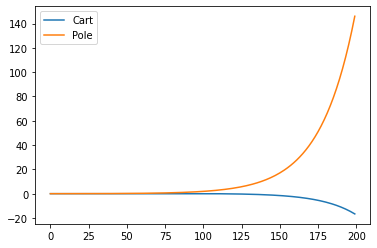

[2] loss: 16149.607


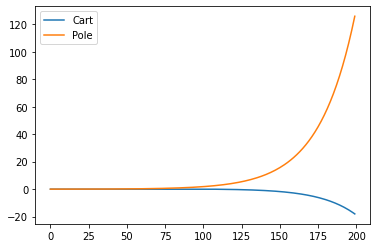

[3] loss: 11203.213


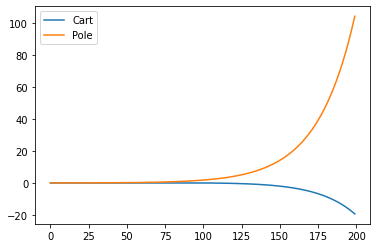

[4] loss: 7791.394


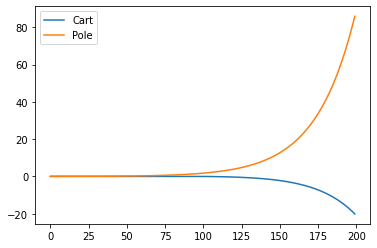

[5] loss: 5597.524


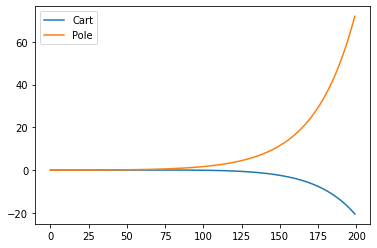

[6] loss: 4073.816


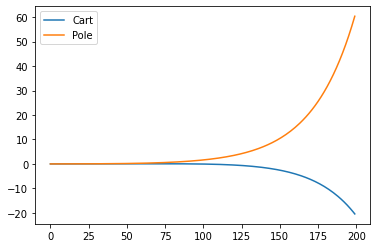

[7] loss: 2958.734


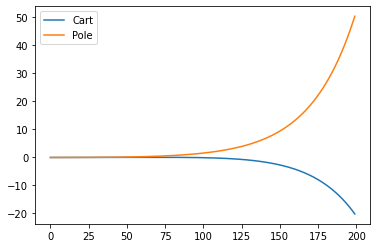

[8] loss: 2143.010


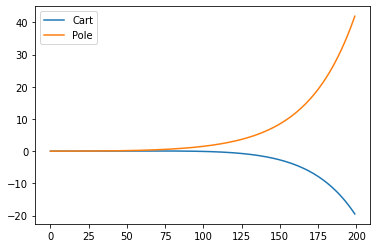

[9] loss: 1504.447


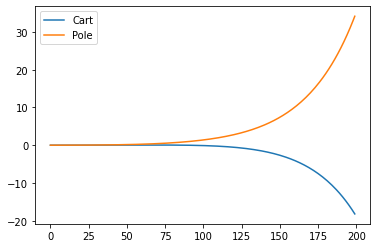

[10] loss: 980.265


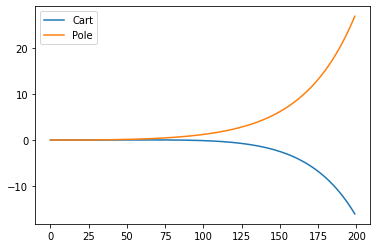

[11] loss: 640.097


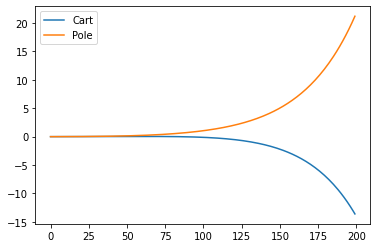

[12] loss: 432.328


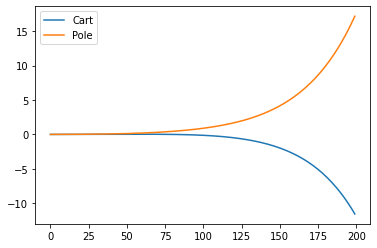

[13] loss: 294.673


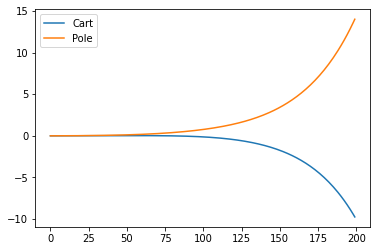

[14] loss: 200.113


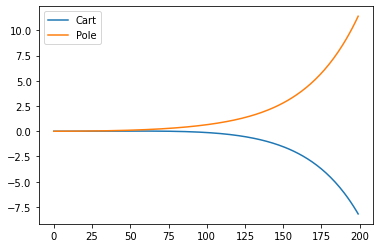

[15] loss: 129.142


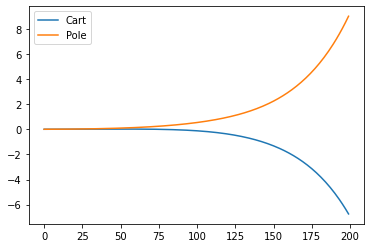

[16] loss: 78.832


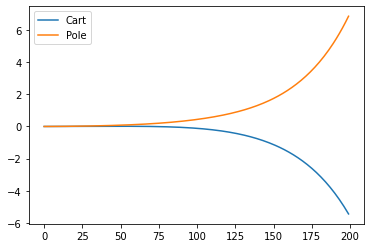

[17] loss: 50.015


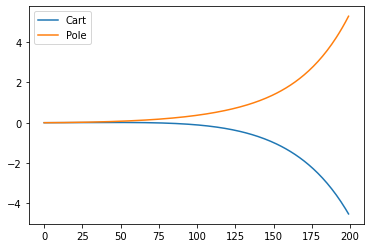

[18] loss: 35.122


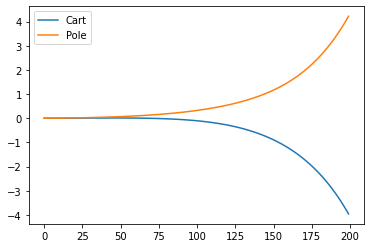

[19] loss: 21.905


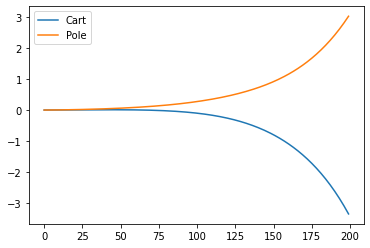

[20] loss: 14.489


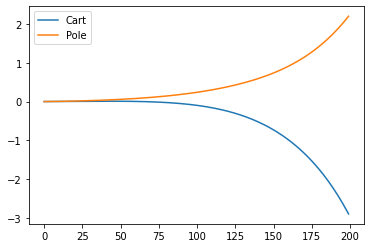

[21] loss: 9.473


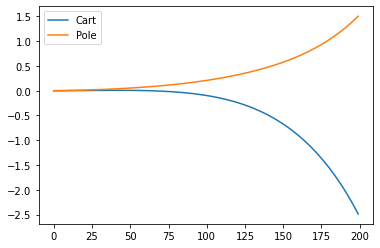

[22] loss: 6.017


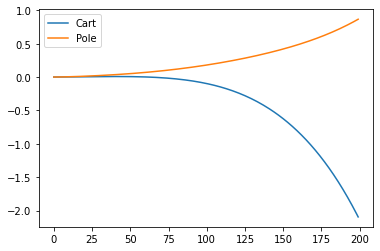

[23] loss: 3.937


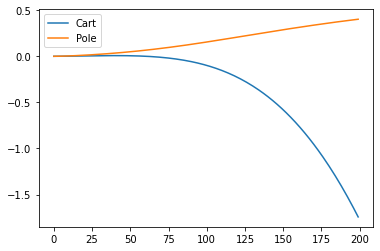

[24] loss: 2.671


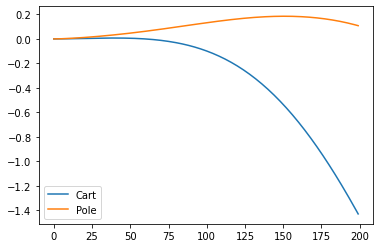

[25] loss: 1.819


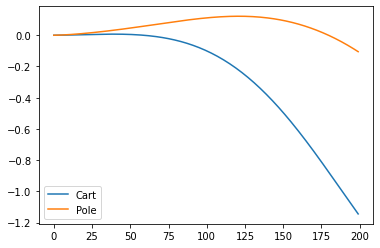

[26] loss: 0.909


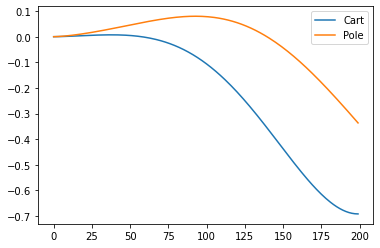

[27] loss: 0.194


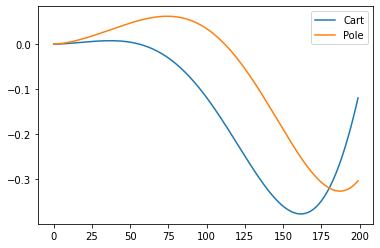

[28] loss: 0.072


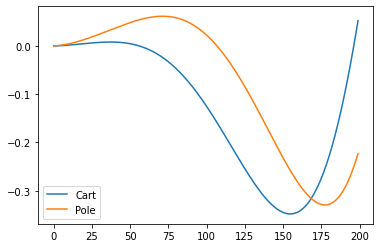

[29] loss: 0.037


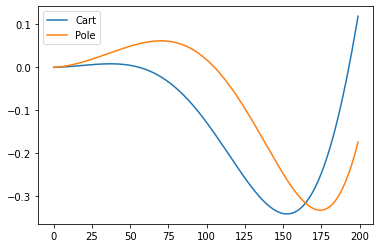

[30] loss: 0.021


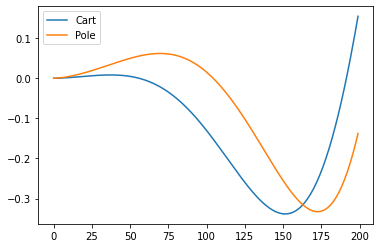

[31] loss: 0.013


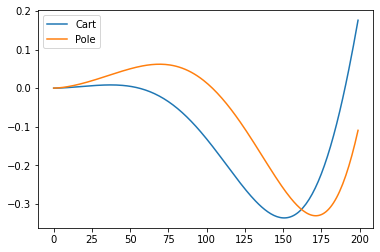

[32] loss: 0.008


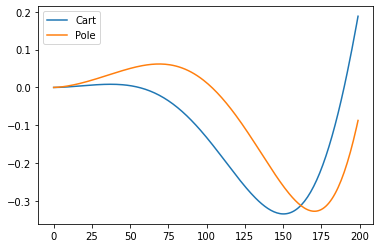

[33] loss: 0.005


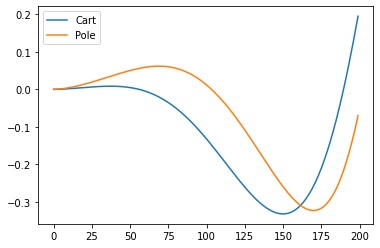

[34] loss: 0.003


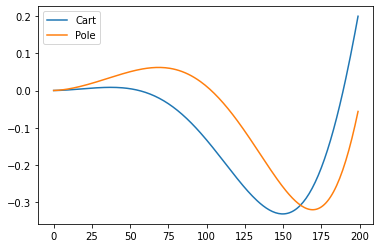

[35] loss: 0.002


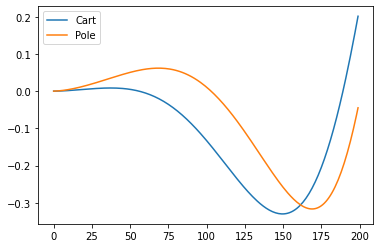

[36] loss: 0.001


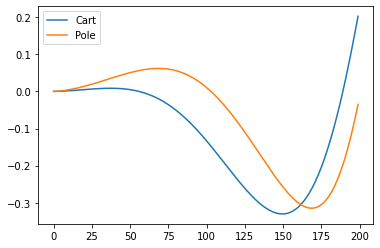

[37] loss: 0.001


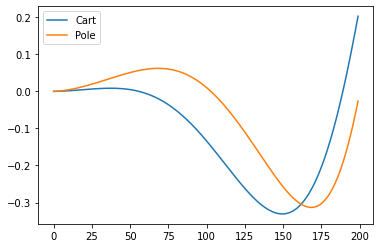

[38] loss: 0.000


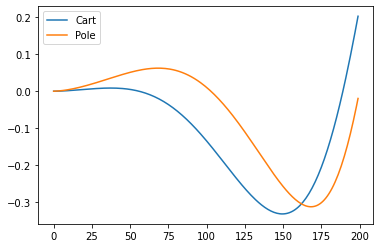

[39] loss: 0.000


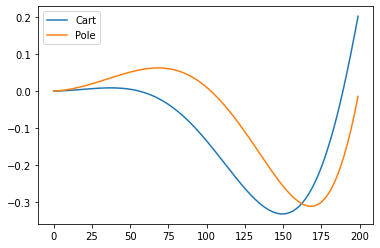

[40] loss: 0.000


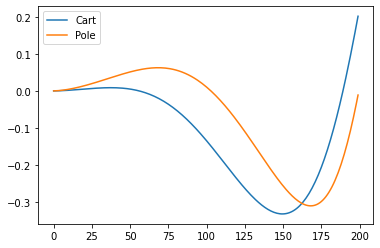

[41] loss: 0.000


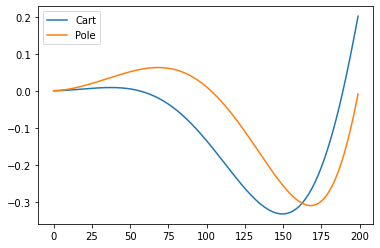

[42] loss: 0.000


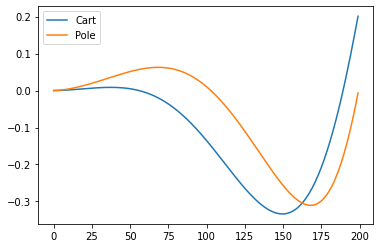

[43] loss: 0.000


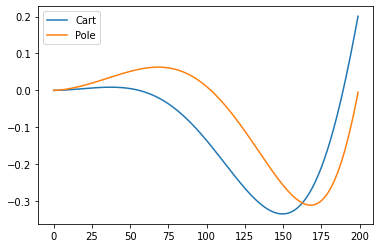

[44] loss: 0.000


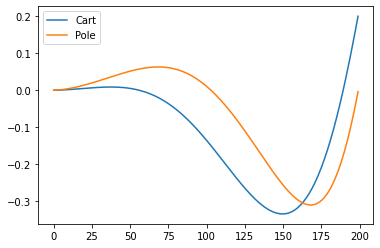

[45] loss: 0.000


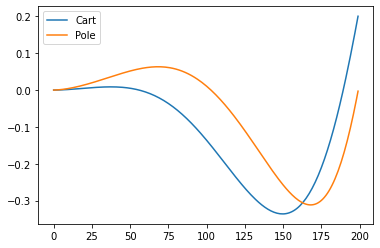

[46] loss: 0.000


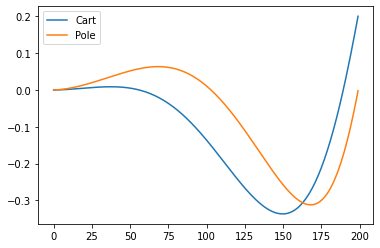

[47] loss: 0.000


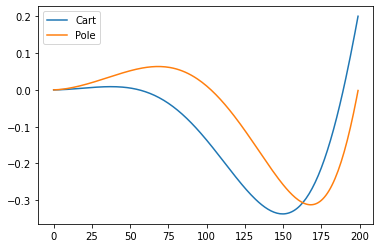

[48] loss: 0.000


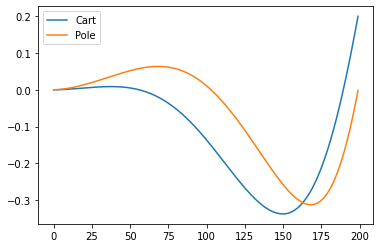

[49] loss: 0.000


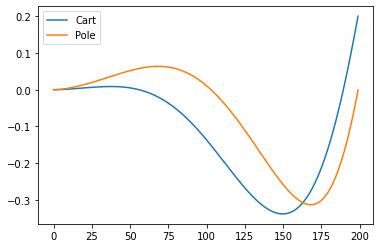

[50] loss: 0.000


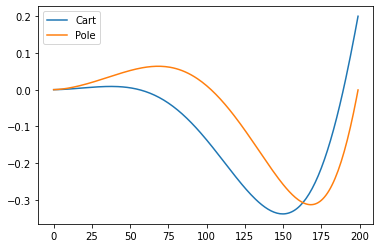

[51] loss: 0.000


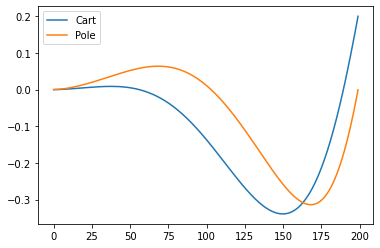

[52] loss: 0.000


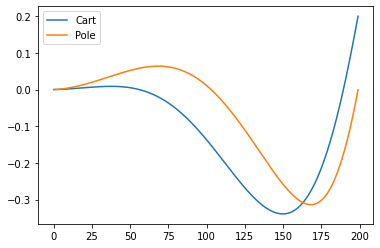

[53] loss: 0.000


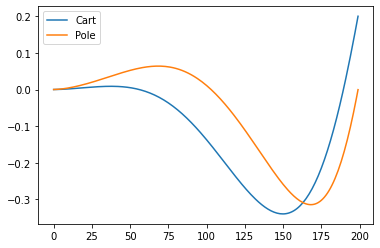

[54] loss: 0.000


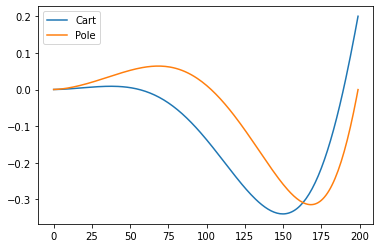

[55] loss: 0.000


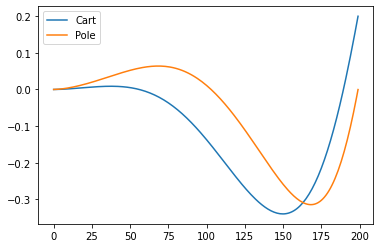

[56] loss: 0.000


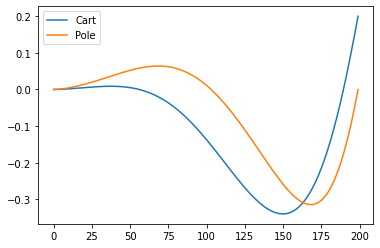

[57] loss: 0.000


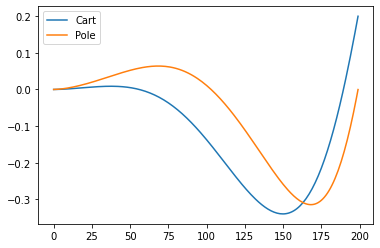

[58] loss: 0.000


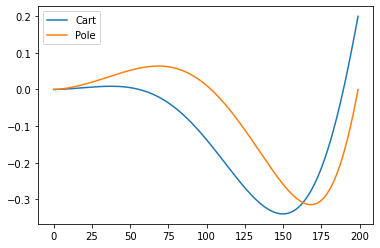

[59] loss: 0.000


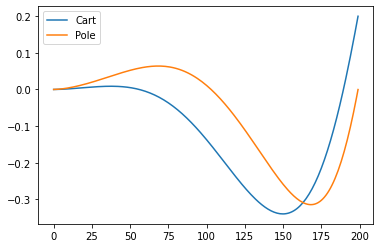

[60] loss: 0.000


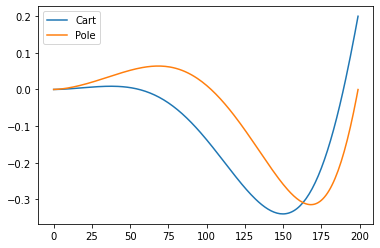

[61] loss: 0.000


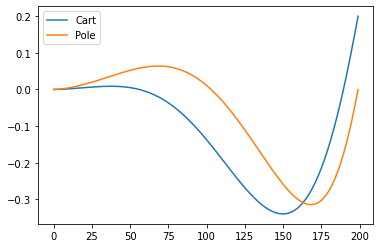

[62] loss: 0.000


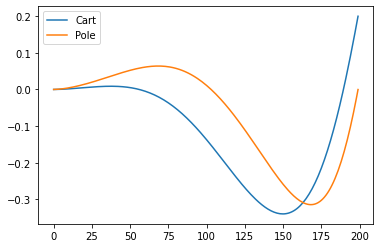

[63] loss: 0.000


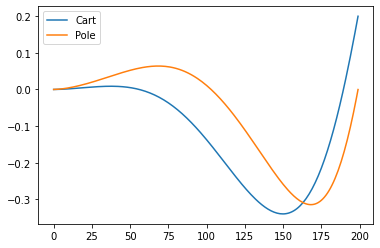

[64] loss: 0.000


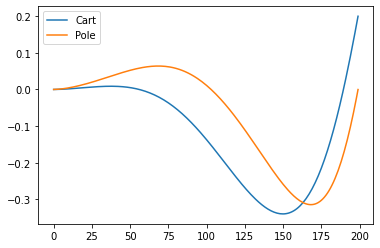

[65] loss: 0.000


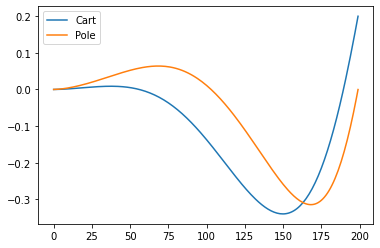

[66] loss: 0.000


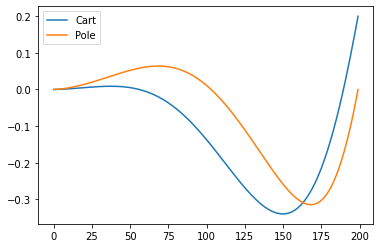

[67] loss: 0.000


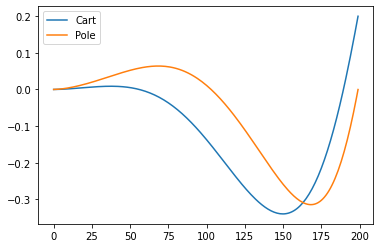

[68] loss: 0.000


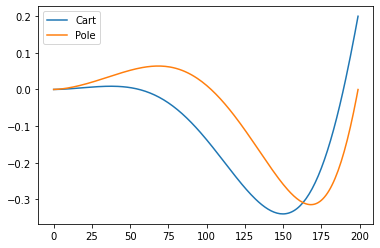

[69] loss: 0.000


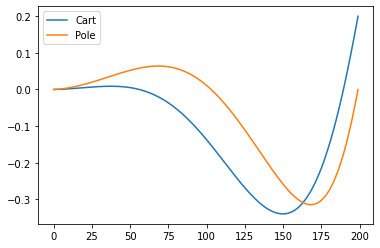

[70] loss: 0.000


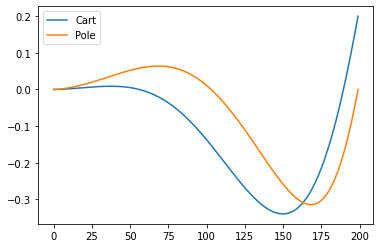

[71] loss: 0.000


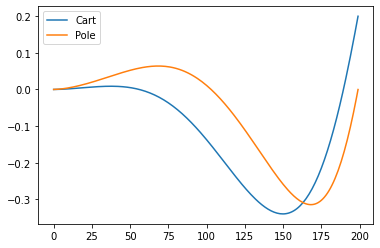

[72] loss: 0.000


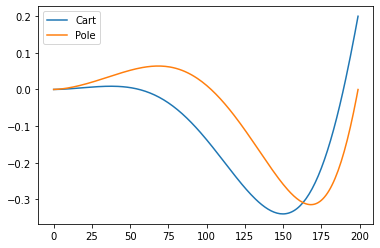

[73] loss: 0.000


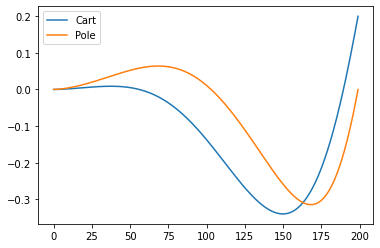

[74] loss: 0.000


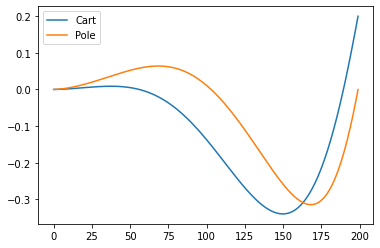

[75] loss: 0.000


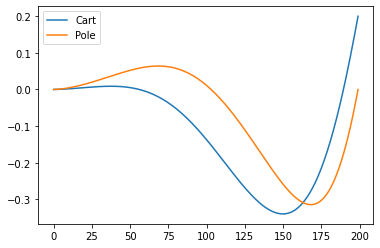

[76] loss: 0.000


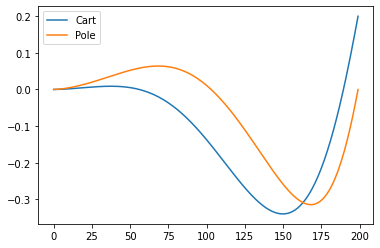

[77] loss: 0.000


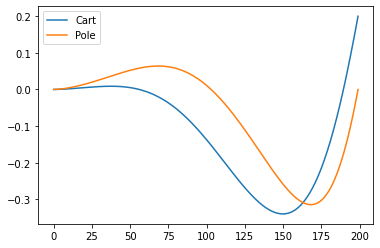

[78] loss: 0.000


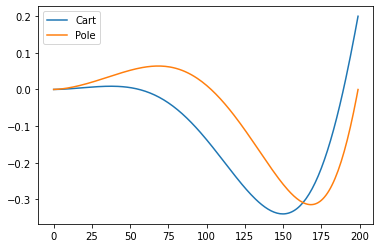

[79] loss: 0.000


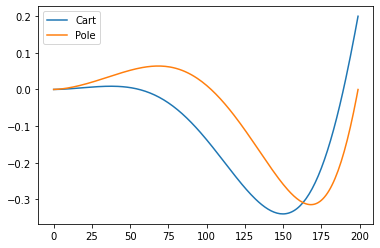

[80] loss: 0.000


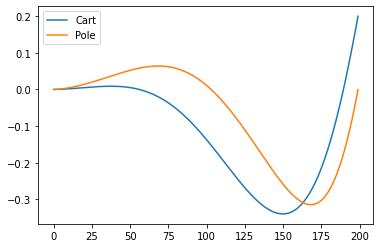

[81] loss: 0.000


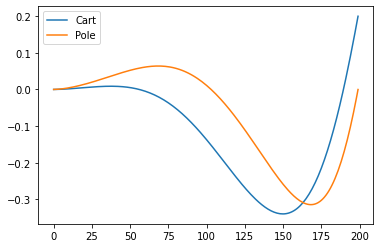

[82] loss: 0.000


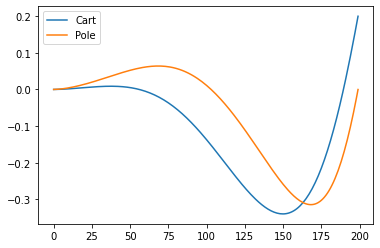

[83] loss: 0.000


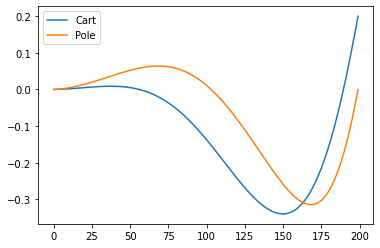

[84] loss: 0.000


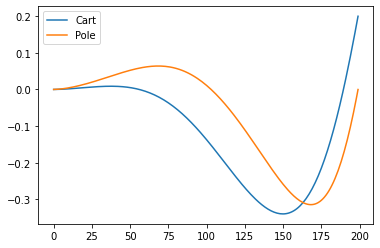

[85] loss: 0.000


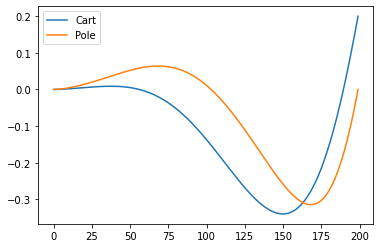

[86] loss: 0.000


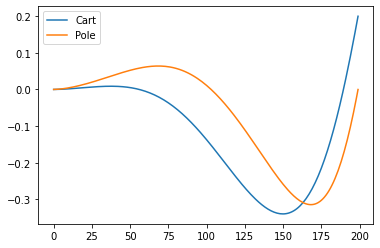

[87] loss: 0.000


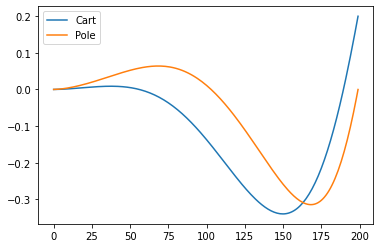

[88] loss: 0.000


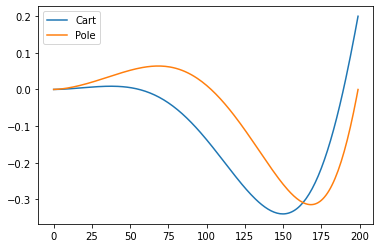

[89] loss: 0.000


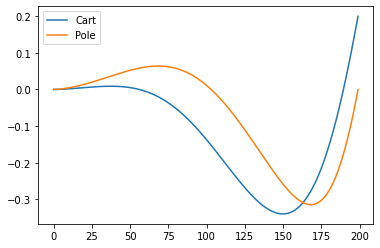

[90] loss: 0.000


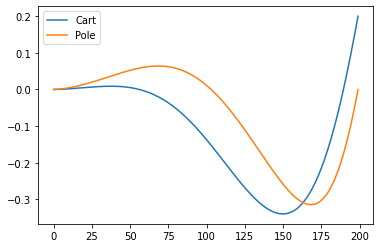

[91] loss: 0.000


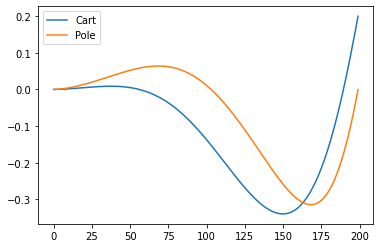

[92] loss: 0.000


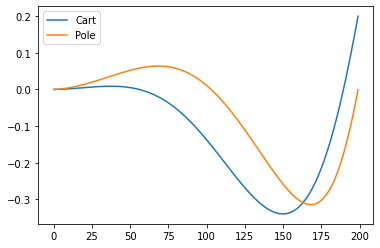

[93] loss: 0.000


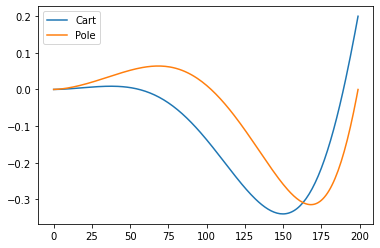

[94] loss: 0.000


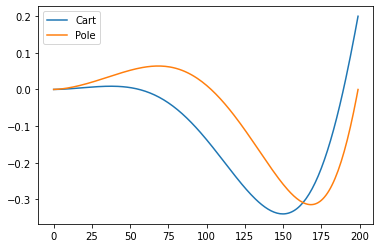

[95] loss: 0.000


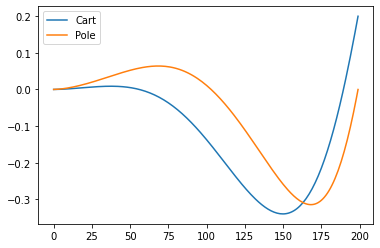

[96] loss: 0.000


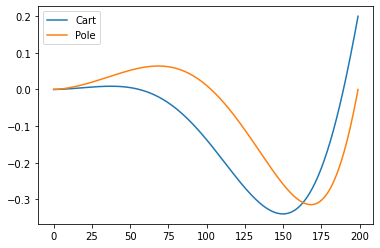

[97] loss: 0.000


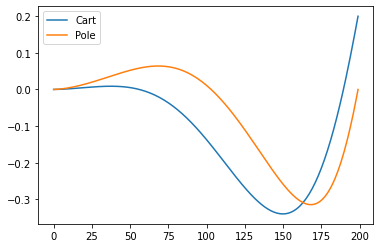

[98] loss: 0.000


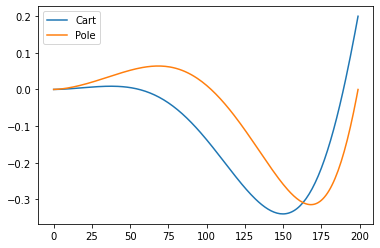

[99] loss: 0.000


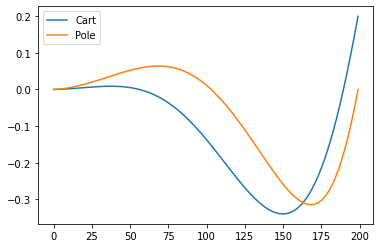

[100] loss: 0.000


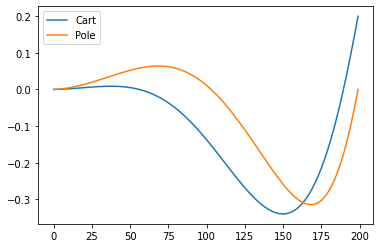

In [505]:
#frame = 0.2
dim_input = 4
dim_output = 4
dim_hidden = 10
#ref = 0.2
T = 200
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c,d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(100)

In [506]:
#data = np.array([s.state_trajectory[i].detach().numpy() for i in range(s.T)])